In [5]:
%load_ext autoreload
%autoreload 2
import sys
import torch
import pickle
import pandas as pd
from torch import nn
import numpy as np
# sys.path.append('..')
# sys.path.append('/system/user/beck/pwbeck/projects/regularization/ml_utilities')
from pathlib import Path
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from tueplots.constants.color import palettes
###
from ml_utilities.torch_models.fc import FC
from ml_utilities.output_loader.model_loader import load_model_from_idx, load_directions_matrix_from_task_sweep, load_multiple_dir_matrices_from_sweep
from ml_utilities.output_loader.job_output import SweepResult, JobResult
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values
###
from erank.data.datasetgenerator import DatasetGenerator
from ml_utilities.data_utils import show_images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gpu_id = 0

# 11.7.1 MNIST Lenet rotatedtasks

In [2]:
# experiment config + output directory
output_dir = '/system/user/beck/pwbeck/projects/regularization/erank/outputs/mnist-11.7.1-lenet_rotatedtasks--221104_083629'
pretrain_dir = '/system/user/beck/pwbeck/projects/regularization/erank/outputs/mnist-11.5.0-lenet--221015_122552'

## A. Pretrain run

In [4]:
jobpr = JobResult(pretrain_dir)
jobpr.is_successful_job, jobpr.override_hpparams, jobpr.data_log_sources, jobpr.progress_measure, jobpr.best_model_idx

(True, {}, ['train_step', 'train', 'val'], 'step', 430)

In [5]:
jobpr.get_summary()

,best_step,best_val_score,seed
mnist-11.5.0-lenet--221015_122552,430,0.96075,0


In [6]:
prdf = jobpr.get_data_log('train')
prdf

,log_step,epoch,train_step,loss_CrossEntropyLoss,Accuracy,time_last_train_epoch_in_s
0,413,1,375,0.299769,0.911146,0.000000
1,541,2,490,0.121593,0.962636,106.144387


In [7]:
prdf = jobpr.get_data_log(['train_step', 'val'])
prdf

,log_step,epoch,train_step,train_step-loss_CrossEntropyLoss,train_step-Accuracy,train_step-weight_norm,val-loss_CrossEntropyLoss,val-Accuracy,val-time_last_val_epoch_in_s
490,0,0,0,NaN,NaN,NaN,2.307779,0.100833,0.000000
0,1,1,0,2.313010,0.101562,11.707621,NaN,NaN,NaN
1,2,1,1,2.201852,0.429688,11.726831,NaN,NaN,NaN
2,3,1,2,2.098251,0.468750,11.752336,NaN,NaN,NaN
3,4,1,3,1.988275,0.539062,11.783297,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
486,536,2,486,0.164481,0.945312,16.577518,NaN,NaN,NaN
487,537,2,487,0.137834,0.953125,16.582777,NaN,NaN,NaN
488,538,2,488,0.083491,0.976562,16.588509,NaN,NaN,NaN
489,539,2,489,0.075387,0.976562,16.595190,NaN,NaN,NaN


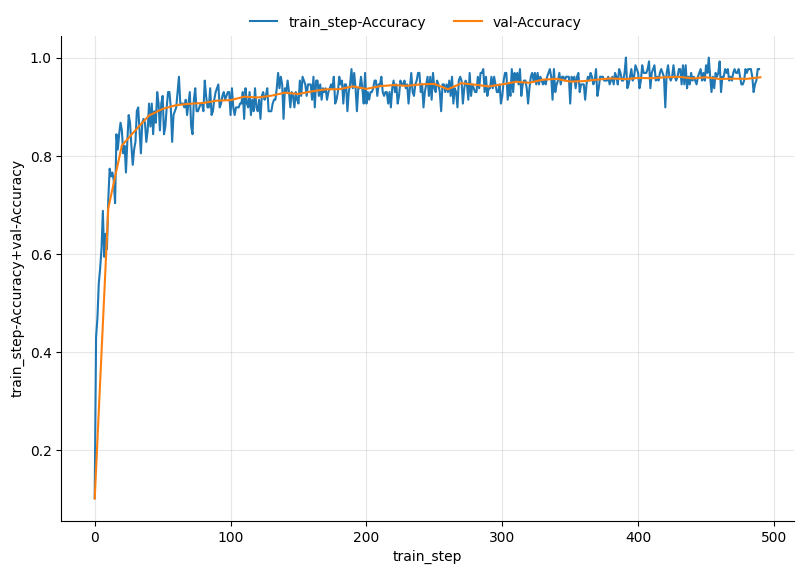

In [8]:
# plot learning curve
f = plot_data_log_values(prdf, x_axis='train_step', y_axis_left=['train_step-Accuracy', 'val-Accuracy'])

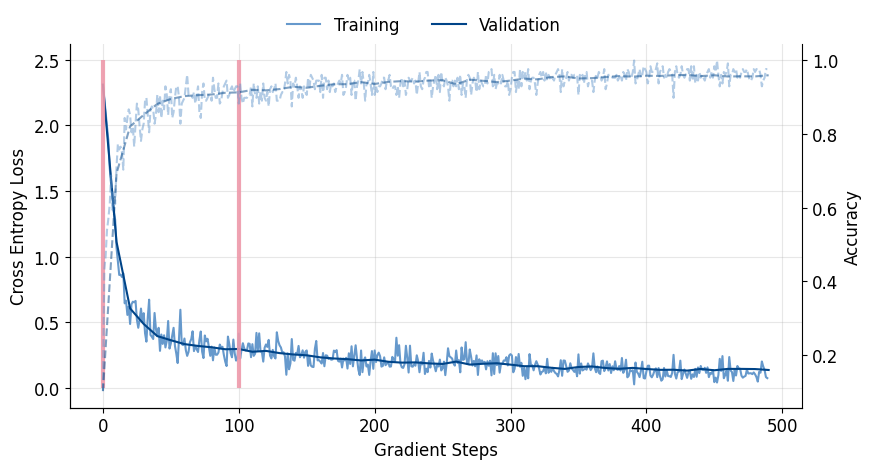

In [105]:
alpha = 0.5
ls = '--'
style_dict = {
    'train_step-loss_CrossEntropyLoss': {
        'label': 'Training'
    },
    'val-loss_CrossEntropyLoss': {
        'label': 'Validation'
    },
    'train_step-Accuracy': {
        'label': '',
        'alpha': alpha,
        'ls': ls
    },
    'val-Accuracy': {
        'label': '',
        'alpha': alpha,
        'ls': ls
    }
}
from ml_utilities.plot import tol_colors
cset = tol_colors.tol_cset('medium-contrast')
with plt.rc_context({'axes.prop_cycle': mpl.cycler('color', cset), 'font.size': 12}):
    f = plot_data_log_values(prdf,
                             x_axis='train_step',
                             y_axis_left=['train_step-loss_CrossEntropyLoss', 'val-loss_CrossEntropyLoss'],
                             y_axis_right=['train_step-Accuracy', 'val-Accuracy'],
                             y_label_left='Cross Entropy Loss',
                             y_label_right='Accuracy',
                             x_label='Gradient Steps',
                             style_dict=style_dict,
                             ylim=(-0.15,2.62),
                             figsize=(2 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54))
    f.axes[0].vlines(x=[0, 100], ymin=0, ymax=2.5, colors=[cset.light_red, cset.light_red], lw=3, alpha=0.9)


In [106]:
f.savefig("pretraining_lenet_mnist_w_marker.png", dpi=300, bbox_inches="tight")

## B. Sweep

### Load Sweep

In [3]:
sweepr = SweepResult(output_dir)
sweepr.sweep_params#, sweepr.get_failed_jobs()

100%|██████████| 2520/2520 [00:10<00:00, 241.06it/s]


(['trainer.init_model_step', 'data.dataset_kwargs.rotation_angle'], [])

In [12]:
print(OmegaConf.to_yaml(sweepr.sweep_dict))

type: grid
axes:
- parameter: trainer.init_model_step
  vals:
  - 0
  - 5
  - 10
  - 20
  - 50
  - 100
  - 480
- parameter: data.dataset_kwargs.rotation_angle
  vals: linspace(0,180,360,endpoint=True)



In [13]:
init_model_step_vals = [0, 5, 10, 100, 480] #[0, 5, 10, 20, 50, 100, 480]
row_sel_train_steps = [0, 5, 10, 30, 100, 500]

In [14]:
sdf = sweepr.get_summary(log_source='val', row_sel=('train_step', row_sel_train_steps), col_sel=['Accuracy'])
sdf

100%|██████████| 2520/2520 [00:54<00:00, 46.10it/s] 


,best_step,best_val_score,Accuracy-train_step-0,Accuracy-train_step-5,Accuracy-train_step-10,Accuracy-train_step-30,Accuracy-train_step-100,Accuracy-train_step-500,trainer.init_model_step,data.dataset_kwargs.rotation_angle,seed
mnist-11.7.1-lenet_rotatedtasks--init_model_step-0-rotation_angle-0.0-seed-0--221106_034610,1095,0.975250,0.100833,0.635333,0.692917,0.851917,0.913250,0.960667,0,0.000000,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-0-rotation_angle-0.5013927576601671-seed-0--221105_053237,1910,0.978167,0.101167,0.634083,0.699917,0.853000,0.912750,0.960250,0,0.501393,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-0-rotation_angle-1.0027855153203342-seed-0--221104_154228,1955,0.979500,0.100417,0.629083,0.711333,0.851250,0.913250,0.961833,0,1.002786,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-0-rotation_angle-1.5041782729805013-seed-0--221104_123652,1540,0.977750,0.100417,0.617333,0.712000,0.853000,0.912750,0.963083,0,1.504178,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-0-rotation_angle-10.027855153203342-seed-0--221107_015554,1910,0.978417,0.099333,0.628000,0.707083,0.850833,0.909250,0.963250,0,10.027855,0
...,...,...,...,...,...,...,...,...,...,...,...
mnist-11.7.1-lenet_rotatedtasks--init_model_step-50-rotation_angle-97.77158774373258-seed-0--221105_101648,1980,0.979250,0.131500,0.356167,0.537917,0.818500,0.907917,0.960667,50,97.771588,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-50-rotation_angle-98.27298050139275-seed-0--221106_012345,1990,0.977917,0.131750,0.355583,0.538833,0.819167,0.906000,0.960750,50,98.272981,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-50-rotation_angle-98.77437325905292-seed-0--221104_170540,1980,0.978000,0.131417,0.355750,0.538583,0.819667,0.907167,0.960667,50,98.774373,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-50-rotation_angle-99.27576601671309-seed-0--221106_210024,1690,0.977083,0.131500,0.354833,0.538167,0.820083,0.907500,0.960500,50,99.275766,0


### Adaptation for different model steps

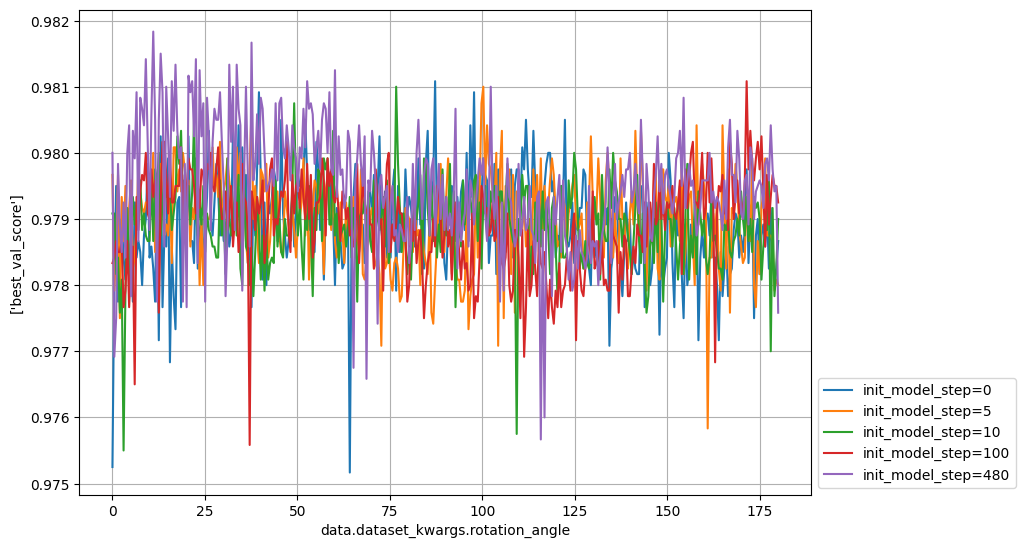

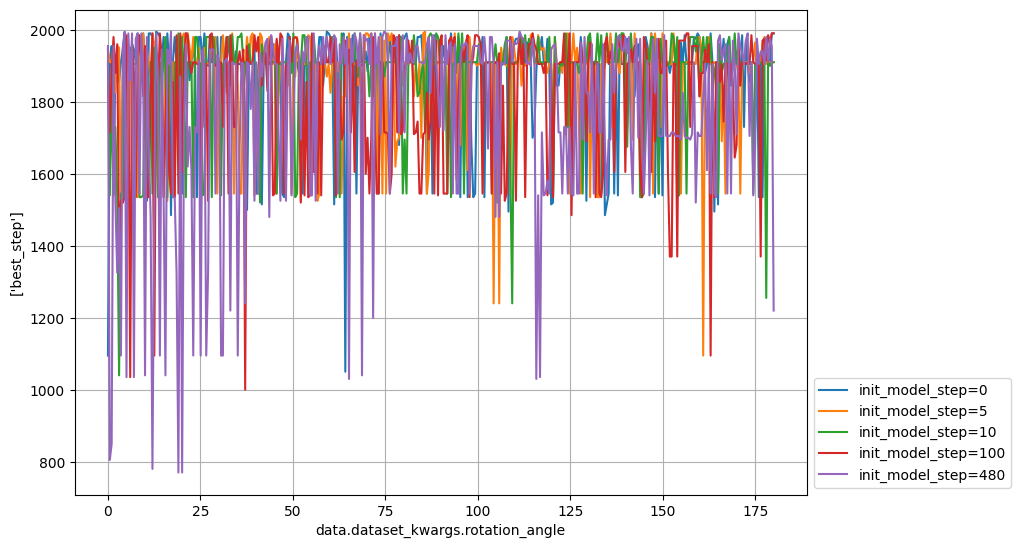

In [15]:
f = plot_sweep_summary(sdf, x_axis='data.dataset_kwargs.rotation_angle', y_axis='best_val_score', compare_parameter='trainer.init_model_step', compare_parameter_val_selection=init_model_step_vals)
f = plot_sweep_summary(sdf, x_axis='data.dataset_kwargs.rotation_angle', y_axis='best_step', compare_parameter='trainer.init_model_step', compare_parameter_val_selection=init_model_step_vals)

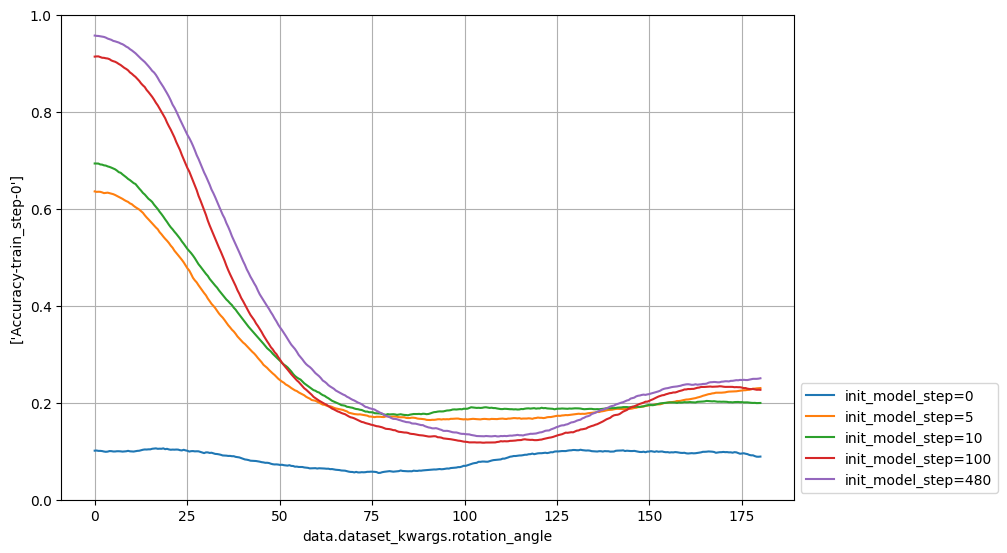

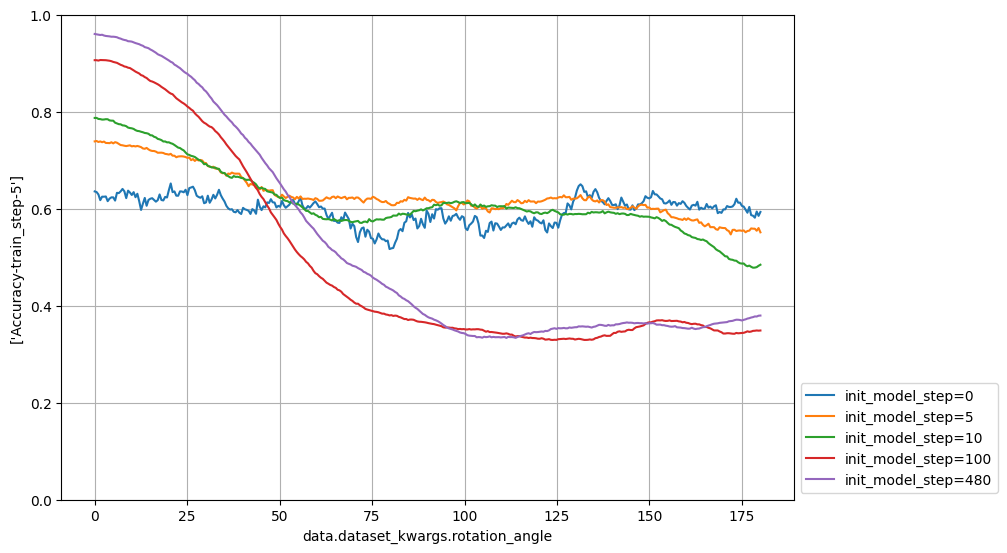

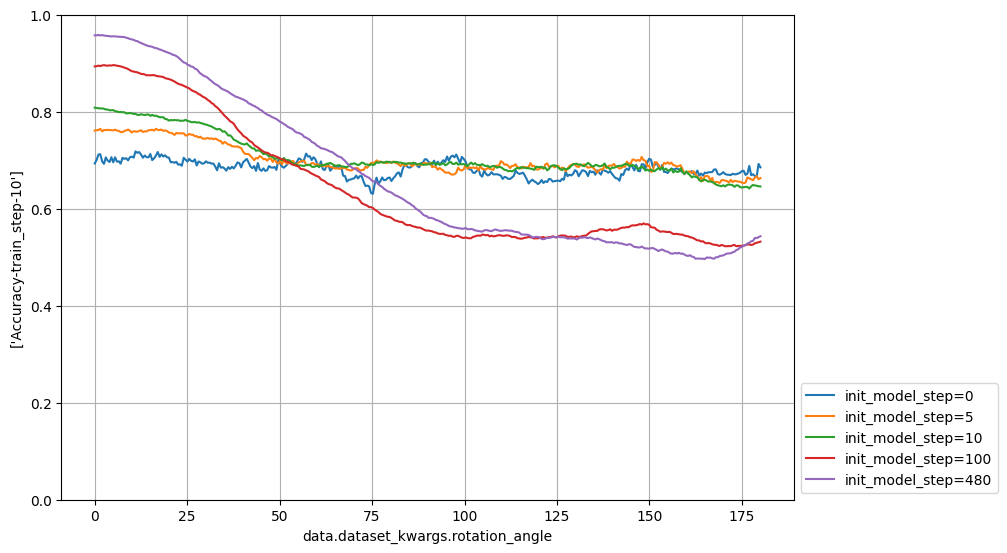

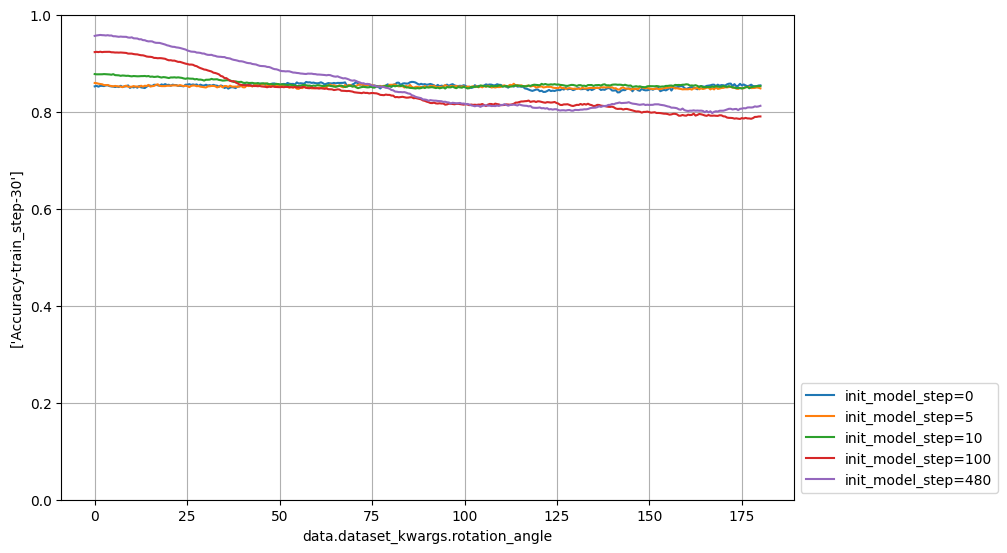

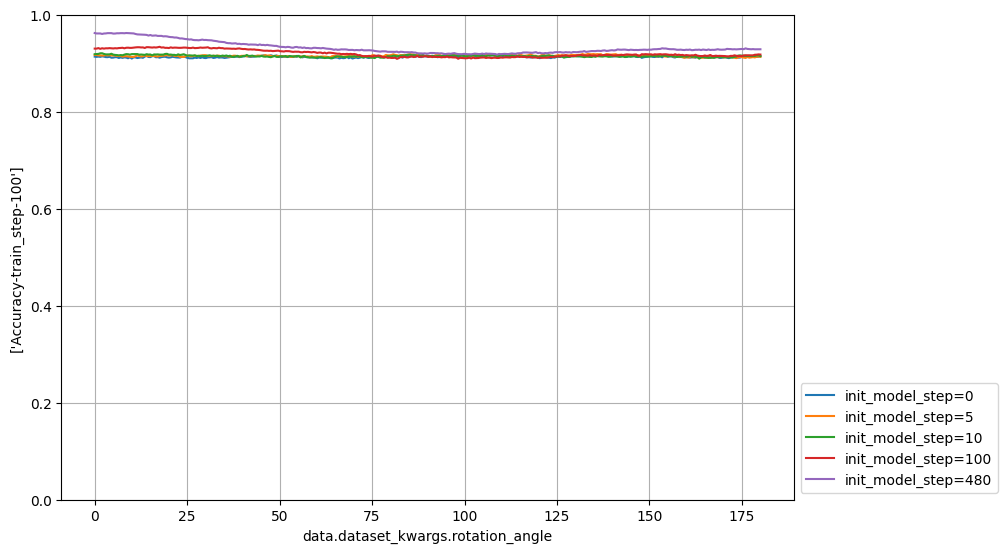

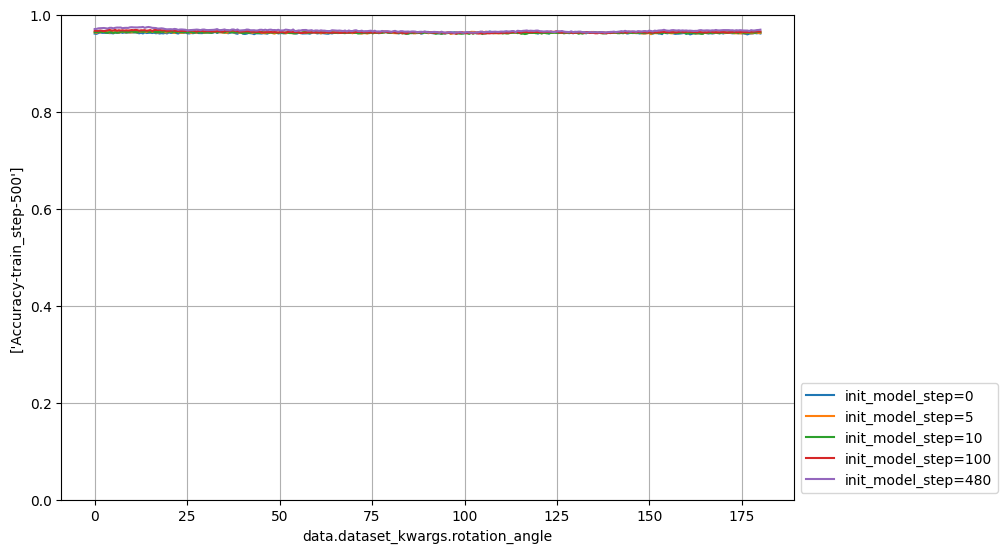

In [16]:
train_steps = row_sel_train_steps
for train_step in row_sel_train_steps:
    f = plot_sweep_summary(sdf, x_axis='data.dataset_kwargs.rotation_angle', y_axis=f'Accuracy-train_step-{train_step}', compare_parameter='trainer.init_model_step', compare_parameter_val_selection=init_model_step_vals, ylim=(0,1.0))

In [17]:
# fig.savefig(f'11_6_mnist_conv4_rotatedtasks_erankplot.png', dpi=300, bbox_inches='tight')

### Plots for Presentation: rot_angle vs. Accuracy for different training length

In [4]:
init_model_step_vals = [0, 100] #[0, 5, 10, 20, 50, 100, 480]
row_sel_train_steps = [0, 5, 10, 30, 100, 500]
sdf2 = sweepr.get_summary(log_source='val', row_sel=('train_step', row_sel_train_steps), col_sel=['Accuracy'])
sdf2

100%|██████████| 2520/2520 [00:54<00:00, 46.07it/s] 


,best_step,best_val_score,Accuracy-train_step-0,Accuracy-train_step-5,Accuracy-train_step-10,Accuracy-train_step-30,Accuracy-train_step-100,Accuracy-train_step-500,trainer.init_model_step,data.dataset_kwargs.rotation_angle,seed
mnist-11.7.1-lenet_rotatedtasks--init_model_step-0-rotation_angle-0.0-seed-0--221106_034610,1095,0.975250,0.100833,0.635333,0.692917,0.851917,0.913250,0.960667,0,0.000000,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-0-rotation_angle-0.5013927576601671-seed-0--221105_053237,1910,0.978167,0.101167,0.634083,0.699917,0.853000,0.912750,0.960250,0,0.501393,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-0-rotation_angle-1.0027855153203342-seed-0--221104_154228,1955,0.979500,0.100417,0.629083,0.711333,0.851250,0.913250,0.961833,0,1.002786,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-0-rotation_angle-1.5041782729805013-seed-0--221104_123652,1540,0.977750,0.100417,0.617333,0.712000,0.853000,0.912750,0.963083,0,1.504178,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-0-rotation_angle-10.027855153203342-seed-0--221107_015554,1910,0.978417,0.099333,0.628000,0.707083,0.850833,0.909250,0.963250,0,10.027855,0
...,...,...,...,...,...,...,...,...,...,...,...
mnist-11.7.1-lenet_rotatedtasks--init_model_step-50-rotation_angle-97.77158774373258-seed-0--221105_101648,1980,0.979250,0.131500,0.356167,0.537917,0.818500,0.907917,0.960667,50,97.771588,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-50-rotation_angle-98.27298050139275-seed-0--221106_012345,1990,0.977917,0.131750,0.355583,0.538833,0.819167,0.906000,0.960750,50,98.272981,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-50-rotation_angle-98.77437325905292-seed-0--221104_170540,1980,0.978000,0.131417,0.355750,0.538583,0.819667,0.907167,0.960667,50,98.774373,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-50-rotation_angle-99.27576601671309-seed-0--221106_210024,1690,0.977083,0.131500,0.354833,0.538167,0.820083,0.907500,0.960500,50,99.275766,0


In [11]:
sdf2[sdf2['trainer.init_model_step']==100].sort_values(by='data.dataset_kwargs.rotation_angle')

,best_step,best_val_score,Accuracy-train_step-0,Accuracy-train_step-5,Accuracy-train_step-10,Accuracy-train_step-30,Accuracy-train_step-100,Accuracy-train_step-500,trainer.init_model_step,data.dataset_kwargs.rotation_angle,seed
mnist-11.7.1-lenet_rotatedtasks--init_model_step-100-rotation_angle-0.0-seed-0--221105_055839,1900,0.978333,0.913250,0.905917,0.893083,0.922583,0.929750,0.966750,100,0.000000,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-100-rotation_angle-0.5013927576601671-seed-0--221107_004915,1715,0.978417,0.913667,0.905833,0.893417,0.923083,0.929750,0.966250,100,0.501393,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-100-rotation_angle-1.0027855153203342-seed-0--221104_231541,1880,0.978667,0.913750,0.905083,0.894667,0.922583,0.930833,0.966417,100,1.002786,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-100-rotation_angle-1.5041782729805013-seed-0--221106_114138,1980,0.978500,0.912250,0.906250,0.893667,0.923333,0.929250,0.967083,100,1.504178,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-100-rotation_angle-2.0055710306406684-seed-0--221104_223546,1880,0.978500,0.910917,0.906167,0.895000,0.922500,0.930500,0.966417,100,2.005571,0
...,...,...,...,...,...,...,...,...,...,...,...
mnist-11.7.1-lenet_rotatedtasks--init_model_step-100-rotation_angle-177.99442896935932-seed-0--221105_225009,1915,0.979333,0.228000,0.347833,0.525667,0.786500,0.915833,0.964583,100,177.994429,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-100-rotation_angle-178.4958217270195-seed-0--221106_102727,1985,0.979667,0.227250,0.348083,0.528417,0.788917,0.917083,0.964917,100,178.495822,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-100-rotation_angle-178.99721448467966-seed-0--221106_023535,1965,0.979500,0.226417,0.348667,0.529417,0.789000,0.917250,0.965250,100,178.997214,0
mnist-11.7.1-lenet_rotatedtasks--init_model_step-100-rotation_angle-179.49860724233983-seed-0--221105_065200,1990,0.979500,0.226583,0.348250,0.530667,0.789833,0.917833,0.964833,100,179.498607,0


In [25]:
from ml_utilities.plot import color_palettes
color_palettes.grad_tol_medium_contrast_lightred_darkblue

array(['994455', '903e62', '813c70', '6a3d7c', '494184', '004488'],
      dtype='<U6')

In [57]:
y_axis = [f'Accuracy-train_step-{train_step}' for train_step in row_sel_train_steps]
pretrain_steps = [0,100]
labels = [f'init_model_step={ps}#{y_ax}' for ps in pretrain_steps for y_ax in y_axis ]
style_dict = {
    'init_model_step=0#Accuracy-train_step-0': dict(label='0'),
    'init_model_step=0#Accuracy-train_step-5': dict(label='5'),
    'init_model_step=0#Accuracy-train_step-10': dict(label='10'),
    'init_model_step=0#Accuracy-train_step-30': dict(label='30'),
    'init_model_step=0#Accuracy-train_step-100': dict(label='100'),
    'init_model_step=0#Accuracy-train_step-500': dict(label='500'),
    'init_model_step=100#Accuracy-train_step-0': dict(label=''),
    'init_model_step=100#Accuracy-train_step-5': dict(label=''),
    'init_model_step=100#Accuracy-train_step-10': dict(label=''),
    'init_model_step=100#Accuracy-train_step-30': dict(label=''),
    'init_model_step=100#Accuracy-train_step-100': dict(label=''),
    'init_model_step=100#Accuracy-train_step-500': dict(label=''),
}

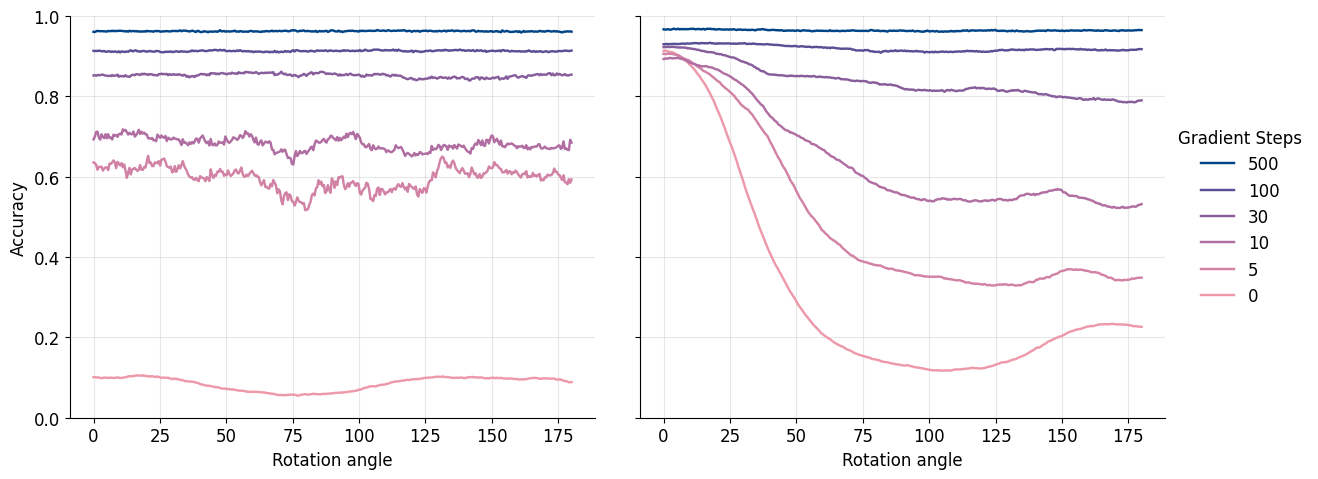

In [67]:
# create plot for rotated experiment
with mpl.rc_context({
        'axes.prop_cycle': mpl.cycler('color', color_palettes.grad_tol_medium_contrast_lightred_darkblue),
        'font.size': 12,
        'lines.linewidth': 1.75
}):
    fig, ax = plt.subplots(1, 2, figsize=(2.5 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54), sharey=True, sharex=True)
    fig.tight_layout()
    ax = ax.tolist()
    f = plot_sweep_summary(sdf2,
                           ax=ax[0],
                           x_axis='data.dataset_kwargs.rotation_angle',
                           y_axis=y_axis,
                           compare_parameter='trainer.init_model_step',
                           compare_parameter_val_selection=[0],
                           y_label='Accuracy',
                           x_label='Rotation angle',
                           style_dict=style_dict,
                           legend_args={},
                           ylim=(0, 1.0))
    f = plot_sweep_summary(sdf2,
                           ax=ax[1],
                           x_axis='data.dataset_kwargs.rotation_angle',
                           y_axis=y_axis,
                           compare_parameter='trainer.init_model_step',
                           compare_parameter_val_selection=[100],
                           y_label=' ',
                           style_dict=style_dict,
                           x_label='Rotation angle',
                           legend_args={},
                           ylim=(0, 1.0))
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles[::-1], labels[::-1], frameon=False, title='Gradient Steps', loc='center left', bbox_to_anchor=(2.08, 0.5), ncol=1)


In [68]:
fig.savefig("trainfromscratch_vs_finetuning_lenet_rotatedmnist.png", dpi=300, bbox_inches="tight")

## C. Dataset

In [34]:
def show_rotated_dataset(rotation_angle, n_images=9, n_cols=3):
    data_cfg = f"""
data:
  dataset: rotatedvision
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data
    dataset: mnist
    rotation_angle: {rotation_angle}
  dataset_split:
    train_val_split: 0.8
"""
    data_cfg = OmegaConf.create(data_cfg)
    data_cfg = data_cfg.data
    dataset_generator = DatasetGenerator(dataset=data_cfg.dataset,
                                     dataset_kwargs=data_cfg.dataset_kwargs,
                                     dataset_split=data_cfg.dataset_split)
    dataset_generator.generate_dataset()
    train_set, val_set = dataset_generator.train_split, dataset_generator.val_split
    show_images(train_set, n_images, n_cols, cmap='gray', shuffle=False, select_idxes=[21, 23, 1, 3, 2, 7, 4, 8, 0], fname=f'mnist_{rotation_angle}.png')
    

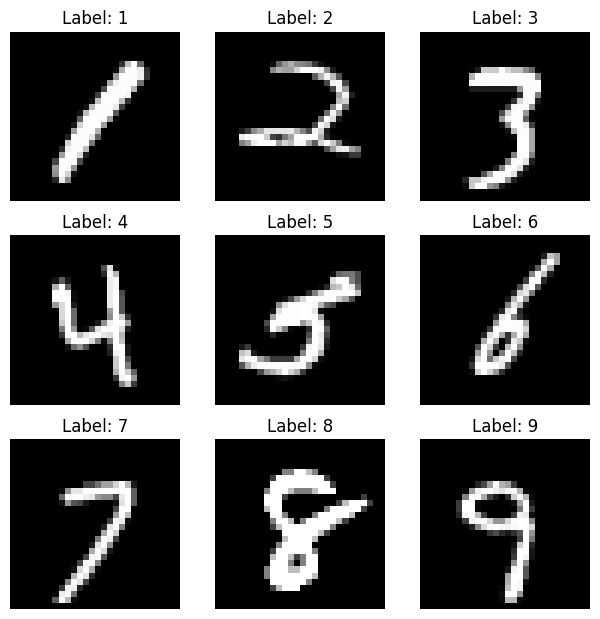

In [35]:
show_rotated_dataset(0)

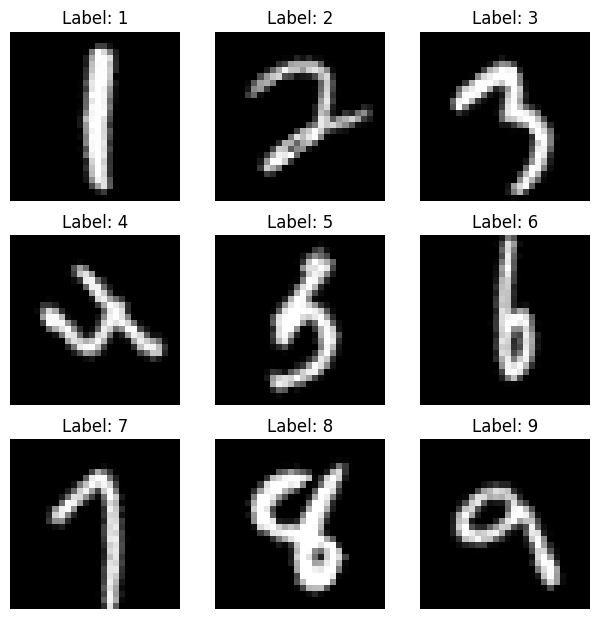

In [36]:
show_rotated_dataset(35.0)

In [14]:
rotation_angle = 0.0
data_cfg = f"""
data:
  dataset: rotatedvision
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data
    dataset: mnist
    rotation_angle: {rotation_angle}
  dataset_split:
    train_val_split: 0.8
"""
data_cfg = OmegaConf.create(data_cfg)
data_cfg = data_cfg.data
dataset_generator = DatasetGenerator(dataset=data_cfg.dataset,
                                     dataset_kwargs=data_cfg.dataset_kwargs,
                                     dataset_split=data_cfg.dataset_split)
dataset_generator.generate_dataset()
train_set, val_set = dataset_generator.train_split, dataset_generator.val_split

In [26]:
# Find indexes such that every digit is in list
labels_to_find = np.arange(1,10).tolist()
labels_remaining = len(labels_to_find)

label_idx_dict = {label: None for label in labels_to_find}

idx = 0
while labels_remaining > 0:
    label = train_set[idx][1]
    if label in label_idx_dict and label_idx_dict[label] is None:
        label_idx_dict[label] = idx
        labels_remaining -= 1
    idx += 1
print(label_idx_dict)
print(list(label_idx_dict.values()))

{1: 21, 2: 23, 3: 1, 4: 3, 5: 2, 6: 7, 7: 4, 8: 8, 9: 0}
[21, 23, 1, 3, 2, 7, 4, 8, 0]
